In [12]:
# This code is to disable warnings that may display this notebook a little bit "ugly"
import warnings
warnings.filterwarnings('ignore')

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.pipeline import Pipeline

import string

from sklearn.learning_curve import learning_curve

from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

from collections import Counter

import pickle

import sys

import random

%matplotlib inline

## get the data

In [14]:
data = pd.DataFrame([])
df =pd.read_csv('data_final.csv',encoding='utf-8',delimiter=';',error_bad_lines=False)
data["text"] = df["sentence"]
data["label"] = df["class"]

## EDA

In [15]:
data.tail(2)

,text,label
234950,قوه خارقه تطبخ الطبخه وتنضف البيت وتدرس الولاد...,levantine
234951,القدره عالاختفاء,levantine


In [16]:
data.head(2)

,text,label
0,اتمنى من الاداره الهلاليه تنبه لمشكلتين في اله...,gulf
1,الة اكبر ما خلو علينا اشي وبحكو ليش بنهاجر وبن...,levantine


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234952 entries, 0 to 234951
Data columns (total 2 columns):
text     234952 non-null object
label    234952 non-null object
dtypes: object(2)
memory usage: 3.6+ MB


## data cleaning

In [8]:
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

In [ ]:
print(arb_stopwords)

In [10]:
def delete_stop_words(mess):
    
    # Now just remove any stopwords
    stop_words = set(nltk.corpus.stopwords.words("arabic"))
    
    return ' '.join(word for word in mess.split() if word not in stop_words and len(word)>1)

In [ ]:
data['text'] = data['text'].apply(delete_stop_words)

### delete any word if its length less than 2

In [19]:
data = data[data.text.map(len) > 2]

In [20]:
data.groupby('label').describe()

text                                                             \
            count  unique                                                top   
label                                                                          
egyptian    22103   22103  غلطان قاذورات للمعرفة العضم هيموت بقو نزيح تكش...   
general     24475   24475  اليس شي غريب انك تقول انك لم تدخل قط الي قسم ش...   
gulf        24169   24169      صدقت واله يعندنا مرشدالفاظه تهدالجبل مع الأسف   
iraqi         291     291      ما دام الغامدي صار يفتي انا بعد بفتي على كيفي   
levantine  137222  137222                        و ازا بوفي الشب بتخون البنت   
maghrebi     9636    9636  وغولام تتراما كتابتي ياشوقآ زميلتي متشتمش ٢٤وب...   
tunisien    16983   16983                                      احلا جو تونسي   

                
          freq  
label           
egyptian     1  
general      1  
gulf         1  
iraqi        1  
levantine    1  
maghrebi     1  
tunisien     1

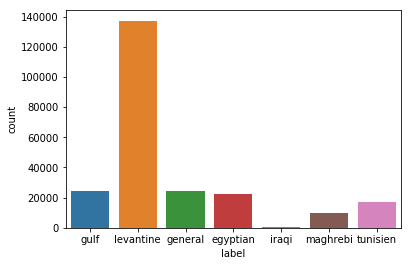

In [21]:
sns.countplot(x="label", data=data)

## Words Representation

### The following code is to show the most representative words per each CATEGORY. While the following code will plot the most representative words per each CATEGORY.

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Plot is being performed! Please wait ...

ValueError: num must be 1 <= num <= 4, not 5

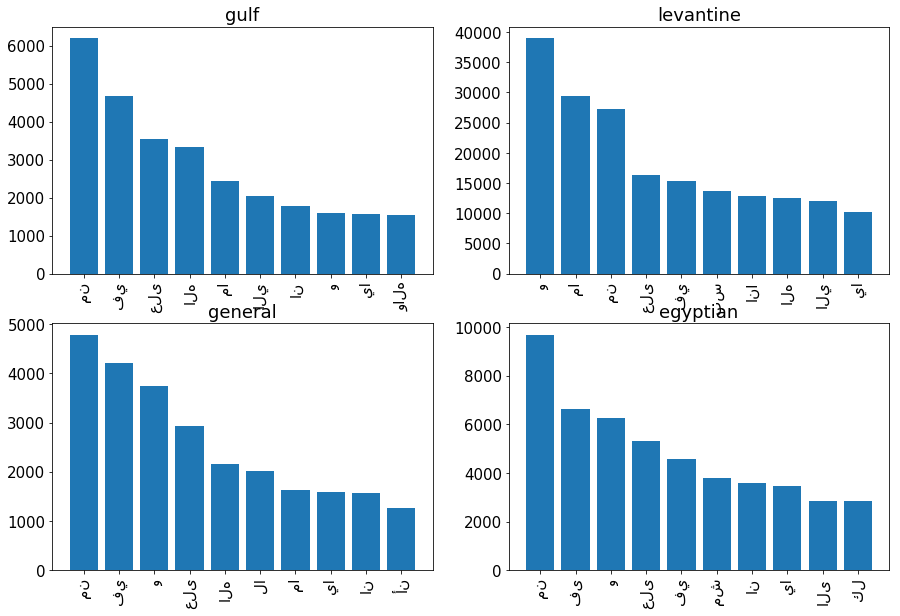

In [22]:
caption_0 = widgets.Label('Enter a number:')
text_0 = widgets.IntText(value=10)
button_0 = widgets.Button(description="Plot")
display(caption_0,text_0,button_0)

def histogram_label():
    n = text_0.value # Top n words
    corpus_size = 0
    i=1
    df = data[['text','label']]
    categories = data.label.unique()
    for category in categories:
            df_text=df.query('label ==  @category')
            result =" ".join(df_text['text'].values.tolist()).split(" ")
            r = pd.DataFrame(result, columns=['WORDS'])
            corpus_size = corpus_size + len(r['WORDS'].unique())
            Counter_=Counter(result).most_common(n)
            labels = [item[0] for item in Counter_]
            number = [item[1] for item in Counter_]
            nbars = len(Counter_)
            plt.subplot(2,2,i)
            plt.xticks(rotation=90,fontsize=15)
            plt.yticks(fontsize=15)
            plt.title(category, fontsize=18)
            plt.bar(np.arange(nbars), number, tick_label=labels)
            i=i+1
    return corpus_size

def handle_submit(sender):
    t = ("Plot is being performed! Please wait ...")
    sys.stdout.write('\r'+t)
    plt.figure(figsize=(15,10))
    s = histogram_label()
    plt.tight_layout()
    sys.stdout.write('\r'+'Corpus Size: ' + str(s))
    sys.stdout.flush()
    
button_0.on_click(handle_submit)

## dialect classification 

In [24]:
X = data.text
y = data.label

In [25]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(164415,) (70464,) (164415,) (70464,)


### using naive bayes classification model
#### use pipeline to pipeline the process: convert words to numbers then tfidf to give importance for each word then train the model
#### use pickle to save the model as a file

In [26]:
from sklearn.naive_bayes import MultinomialNB

# Initializing Pipline
pipelineNB = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts   ====  analyzer=normalize_text
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors
])

# Training the model
pipelineNB.fit(X_train, y_train)

# Saving training results using Pickle
with open('pipelineNB.pickle', 'wb') as handle:
    pickle.dump(pipelineNB, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Predictions
predictionsNB = pipelineNB.predict(X_test)

# Model Evaluation
print(classification_report(predictionsNB, y_test))

             precision    recall  f1-score   support

   egyptian       0.38      0.97      0.55      2665
    general       0.18      0.99      0.30      1281
       gulf       0.23      0.96      0.38      1795
      iraqi       0.00      0.00      0.00         0
  levantine       1.00      0.66      0.80     61719
   maghrebi       0.05      0.99      0.09       137
   tunisien       0.56      0.99      0.71      2867

avg / total       0.92      0.70      0.76     70464



In [27]:
with open('pipelineNB.pickle', 'rb') as handle:
    NB = pickle.load(handle)
NB.predict(["شكون حالك"])[0]

'levantine'

In [28]:
NB.predict(["هوا في ايه"])[0]

'levantine'

In [29]:
NB.predict(["انا عاوز أوجه تحيه للدوله العميقه اللى كل يوم بتثبت ان البلد دى فيها رجاله عارفه بتعمل ايه فعلا و امتى و ازاى ، فى اسبوعي…"])[0]

'egyptian'

In [30]:
NB.predict(["انا خوش مشتاقلك"])[0]

'levantine'

In [33]:
NB.predict(["إلا لا و على دارهم و شنوة تقصد بيها الكلمة باش تقراو "])[0]

'maghrebi'

In [30]:
NB.predict(["انا خوش مشتاقلك"])[0]

'levantine'

In [38]:
NB.predict(["يولد جميع الناس أحرارا ومتساوين في الكرامة والحقوق. وهم قد وهبوا العقل والوجدان وعليهم أن"])[0]

'levantine'

### cross validation

In [34]:
%time scoresNB = cross_val_score(pipelineNB, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresNB))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresNB.mean(), scoresNB.std()))
scoresNB = scoresNB.mean()

Wall time: 1min 28s
Cross-validation scores: [0.69068905 0.69220009 0.68969712 0.68930385 0.69025822]
Average cross-validation score: 0.69 +/- 0.00


#### learining curve

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    This function is to generate a simple plot of the test and traning learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Wall time: 2min 33s


<module 'matplotlib.pyplot' from 'C:\\Users\\youne\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

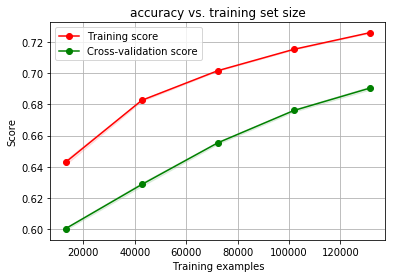

In [36]:
%time plot_learning_curve(pipelineNB, "accuracy vs. training set size", X_train, y_train, cv=5)